In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from easyfsl.samplers import TaskSampler
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [4]:


# Custom transformation to apply grayscale, thresholding, and color inversion
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, image):
        # Convert to grayscale
        image = transforms.Grayscale(num_output_channels=1)(image)
        # Convert to numpy array for processing
        image = np.array(image)
        # Thresholding to binary image
        binary_image = np.where(image > 128, 255, 0).astype(np.uint8)
        # Invert colors (black background, white text)
        inverted_image = 255 - binary_image
        # Convert back to PIL image
        image = Image.fromarray(inverted_image)
        # Convert grayscale image to 3 channels
        image = image.convert("RGB")
        # Resize to the desired size
        image = transforms.Resize((self.image_size, self.image_size))(image)
        # Convert to tensor
        image = transforms.ToTensor()(image)
        return image

# Define constants
N_WAY = 2
N_SHOT = 5
N_QUERY = 10
N_TRAINING_EPISODES = 200
N_VALIDATION_TASKS = 100
image_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
train_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
])

# Load datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)

test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=test_transforms
)

train_set.get_labels = lambda: train_set.targets
test_set.get_labels = lambda: test_set.targets

# Create task samplers
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

# Create data loaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

# Define model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ])

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate_on_one_task(support_images, support_labels, query_images, query_labels):
    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)

def evaluate(data_loader):
    total_predictions = 0
    correct_predictions = 0

    model.eval()
    with torch.no_grad():
        for _, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct

    accuracy = (100 * correct_predictions / total_predictions)
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2f}%")

# Training loop
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=np.mean(all_loss[-log_update_frequency:]))

# Save the trained model
model_save_path = "/Users/gyaani/Desktop/prototypical_network.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")



100%|███████████████████████████| 200/200 [03:14<00:00,  1.03it/s, loss=5.76e-6]

Model saved to /Users/gyaani/Desktop/prototypical_network.pth


/Users/gyaani/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gyaani/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

Confusion Matrix:
[[15  5]
 [ 4 16]]
Accuracy: 77.50%


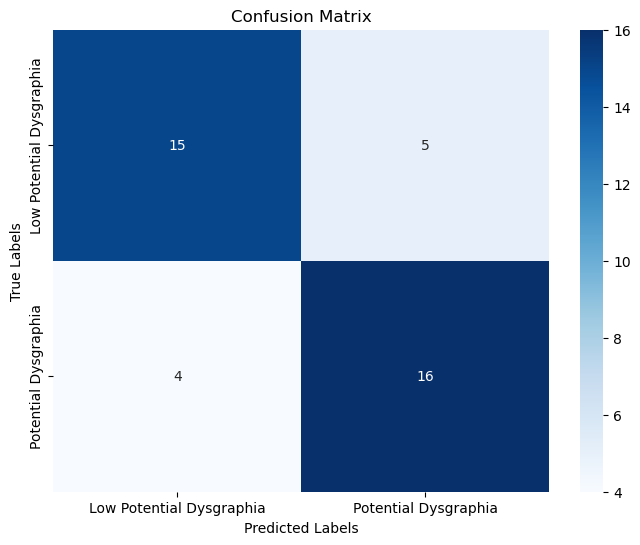

In [25]:


# Custom transformation to apply grayscale, thresholding, and color inversion
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, image):
        # Convert to grayscale
        image = transforms.Grayscale(num_output_channels=1)(image)
        # Convert to numpy array for processing
        image = np.array(image)
        # Thresholding to binary image
        binary_image = np.where(image > 128, 255, 0).astype(np.uint8)
        # Invert colors (black background, white text)
        inverted_image = 255 - binary_image
        # Convert back to PIL image
        image = Image.fromarray(inverted_image)
        # Convert grayscale image to 3 channels
        image = image.convert("RGB")
        # Resize to the desired size
        image = transforms.Resize((self.image_size, self.image_size))(image)
        # Convert to tensor
        image = transforms.ToTensor()(image)
        return image

# Define constants
N_WAY = 2
N_SHOT = 5
N_QUERY = 20
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 1
image_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define transformations
train_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
])

# Load datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)

test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=test_transforms
)

train_set.get_labels = lambda: train_set.targets
test_set.get_labels = lambda: test_set.targets

# Create task samplers
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

# Create data loaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

# Define model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ])

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

def sliding_average(data, window_size):
    return np.mean(data[-window_size:])

def evaluate_on_one_task(support_images, support_labels, query_images, query_labels):
    scores = model(support_images.to(device), support_labels.to(device), query_images.to(device))
    predicted_labels = torch.max(scores, 1)[1].detach().cpu().numpy()
    true_labels = query_labels.to(device).cpu().numpy()
    return predicted_labels, true_labels

def evaluate(data_loader):
    all_predicted_labels = []
    all_true_labels = []

    model.eval()
    with torch.no_grad():
        for _, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            predicted_labels, true_labels = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            all_predicted_labels.extend(predicted_labels)
            all_true_labels.extend(true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    accuracy = (np.array(all_predicted_labels) == np.array(all_true_labels)).mean() * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Print confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_loader.dataset.classes, yticklabels=data_loader.dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model
evaluate(test_loader)


## Cude Euclidean distances

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Confusion Matrix:
[[15  5]
 [ 1 19]]
Accuracy: 85.00%


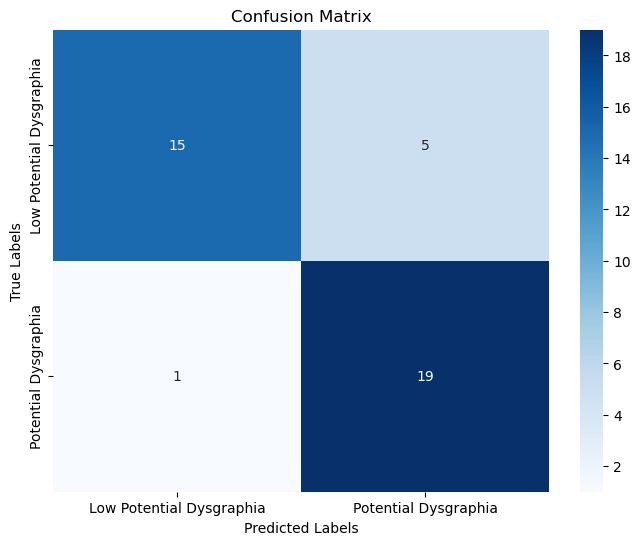

In [24]:
# Custom transformation to apply grayscale, thresholding, and color inversion
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, image):
        # Convert to grayscale
        image = transforms.Grayscale(num_output_channels=1)(image)
        # Convert to numpy array for processing
        image = np.array(image)
        # Thresholding to binary image
        binary_image = np.where(image > 128, 255, 0).astype(np.uint8)
        # Invert colors (black background, white text)
        inverted_image = 255 - binary_image
        # Convert back to PIL image
        image = Image.fromarray(inverted_image)
        # Convert grayscale image to 3 channels
        image = image.convert("RGB")
        # Resize to the desired size
        image = transforms.Resize((self.image_size, self.image_size))(image)
        # Convert to tensor
        image = transforms.ToTensor()(image)
        return image

# Define constants
N_WAY = 2
N_SHOT = 5
N_QUERY = 20
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 1
image_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
train_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
])

# Load datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)

test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=test_transforms
)

train_set.get_labels = lambda: train_set.targets
test_set.get_labels = lambda: test_set.targets

# Create task samplers
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

# Create data loaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

# Define model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ])

        # Calculate the Euclidean distance
        dists = torch.cdist(z_query, z_proto)
        
        # Cube the Euclidean distances
        dists_cubed = dists ** 3

        # Convert distances to classification scores (lower distance = higher score)
        scores = -dists_cubed
        return scores

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

def sliding_average(data, window_size):
    return np.mean(data[-window_size:])

def evaluate_on_one_task(support_images, support_labels, query_images, query_labels):
    scores = model(support_images.to(device), support_labels.to(device), query_images.to(device))
    predicted_labels = torch.max(scores, 1)[1].detach().cpu().numpy()
    true_labels = query_labels.to(device).cpu().numpy()
    return predicted_labels, true_labels

def evaluate(data_loader):
    all_predicted_labels = []
    all_true_labels = []

    model.eval()
    with torch.no_grad():
        for _, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            predicted_labels, true_labels = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            all_predicted_labels.extend(predicted_labels)
            all_true_labels.extend(true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    accuracy = (np.array(all_predicted_labels) == np.array(all_true_labels)).mean() * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Print confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_loader.dataset.classes, yticklabels=data_loader.dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model
evaluate(test_loader)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]

Confusion Matrix:
[[19  1]
 [ 7 13]]
Accuracy: 80.00%


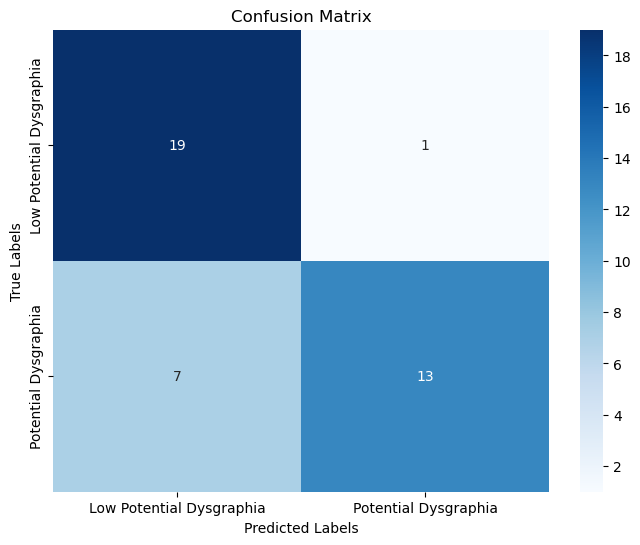

In [30]:
# Custom transformation to apply grayscale, thresholding, and color inversion
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, image):
        # Convert to grayscale
        image = transforms.Grayscale(num_output_channels=1)(image)
        # Convert to numpy array for processing
        image = np.array(image)
        # Thresholding to binary image
        binary_image = np.where(image > 128, 255, 0).astype(np.uint8)
        # Invert colors (black background, white text)
        inverted_image = 255 - binary_image
        # Convert back to PIL image
        image = Image.fromarray(inverted_image)
        # Convert grayscale image to 3 channels
        image = image.convert("RGB")
        # Resize to the desired size
        image = transforms.Resize((self.image_size, self.image_size))(image)
        # Convert to tensor
        image = transforms.ToTensor()(image)
        return image

# Define constants
N_WAY = 2
N_SHOT = 5
N_QUERY = 20
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 1
image_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
train_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
])

# Load datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)

test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=test_transforms
)

train_set.get_labels = lambda: train_set.targets
test_set.get_labels = lambda: test_set.targets

# Create task samplers
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

# Create data loaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.stack([
            z_support[torch.nonzero(support_labels == label).squeeze()].mean(0)
            for label in range(n_way)
        ])

        # Ensure z_proto is 2D
        if z_proto.dim() == 1:
            z_proto = z_proto.unsqueeze(0)
        
        # Ensure z_query is 2D
        if z_query.dim() == 1:
            z_query = z_query.unsqueeze(0)

        # Calculate the Euclidean distance
        dists = torch.cdist(z_query, z_proto)

        # Calculate mean and standard deviation for each class prototype
        mean_dists = dists.mean(dim=0)
        std_dists = dists.std(dim=0)
        
        # Compute the score as mean + 3 * std deviation
        threshold_dists = mean_dists + 3 * std_dists

        # Convert distances to scores
        scores = -dists

        return scores


    
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

def sliding_average(data, window_size):
    return np.mean(data[-window_size:])

def evaluate_on_one_task(support_images, support_labels, query_images, query_labels):
    scores = model(support_images.to(device), support_labels.to(device), query_images.to(device))
    predicted_labels = torch.max(scores, 1)[1].detach().cpu().numpy()
    true_labels = query_labels.to(device).cpu().numpy()
    return predicted_labels, true_labels

def evaluate(data_loader):
    all_predicted_labels = []
    all_true_labels = []

    model.eval()
    with torch.no_grad():
        for _, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            predicted_labels, true_labels = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            all_predicted_labels.extend(predicted_labels)
            all_true_labels.extend(true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    accuracy = (np.array(all_predicted_labels) == np.array(all_true_labels)).mean() * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Print confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_loader.dataset.classes, yticklabels=data_loader.dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model
evaluate(test_loader)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]

Confusion Matrix:
[[ 7 13]
 [ 0 20]]
Accuracy: 67.50%


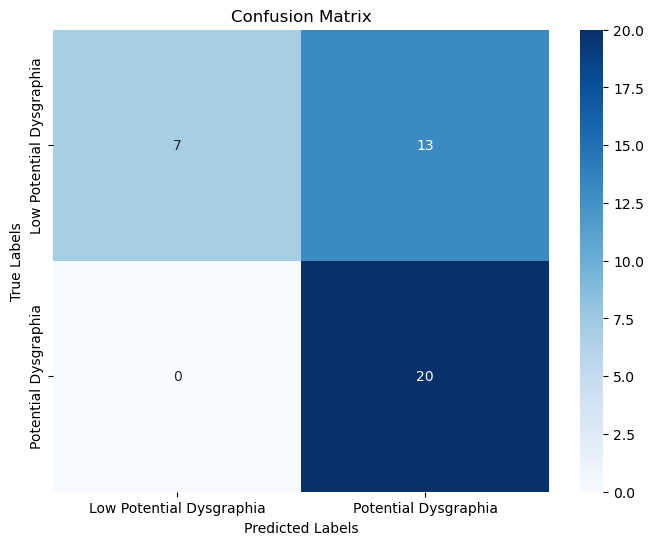

In [32]:
# Custom transformation to apply grayscale, thresholding, and color inversion
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, image):
        # Convert to grayscale
        image = transforms.Grayscale(num_output_channels=1)(image)
        # Convert to numpy array for processing
        image = np.array(image)
        # Thresholding to binary image
        binary_image = np.where(image > 128, 255, 0).astype(np.uint8)
        # Invert colors (black background, white text)
        inverted_image = 255 - binary_image
        # Convert back to PIL image
        image = Image.fromarray(inverted_image)
        # Convert grayscale image to 3 channels
        image = image.convert("RGB")
        # Resize to the desired size
        image = transforms.Resize((self.image_size, self.image_size))(image)
        # Convert to tensor
        image = transforms.ToTensor()(image)
        return image

# Define constants
N_WAY = 2
N_SHOT = 5
N_QUERY = 20
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 1
image_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
train_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
])

# Load datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)

test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=test_transforms
)

train_set.get_labels = lambda: train_set.targets
test_set.get_labels = lambda: test_set.targets

# Create task samplers
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

# Create data loaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.stack([
            z_support[torch.nonzero(support_labels == label).squeeze()].mean(0)
            for label in range(n_way)
        ])

        # Ensure z_proto is 2D
        if z_proto.dim() == 1:
            z_proto = z_proto.unsqueeze(0)
        
        # Ensure z_query is 2D
        if z_query.dim() == 1:
            z_query = z_query.unsqueeze(0)

        # Calculate the Euclidean distance
        dists = torch.cdist(z_query, z_proto)

        # Calculate mean and standard deviation for each class prototype
        mean_dists = dists.mean(dim=0)
        std_dists = dists.std(dim=0)
        
        # Compute the score as mean + 3 * std deviation
        threshold_dists = mean_dists - 3 * std_dists

        # Convert distances to scores
        scores = -dists

        return scores


    
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

def sliding_average(data, window_size):
    return np.mean(data[-window_size:])

def evaluate_on_one_task(support_images, support_labels, query_images, query_labels):
    scores = model(support_images.to(device), support_labels.to(device), query_images.to(device))
    predicted_labels = torch.max(scores, 1)[1].detach().cpu().numpy()
    true_labels = query_labels.to(device).cpu().numpy()
    return predicted_labels, true_labels

def evaluate(data_loader):
    all_predicted_labels = []
    all_true_labels = []

    model.eval()
    with torch.no_grad():
        for _, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            predicted_labels, true_labels = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            all_predicted_labels.extend(predicted_labels)
            all_true_labels.extend(true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    accuracy = (np.array(all_predicted_labels) == np.array(all_true_labels)).mean() * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Print confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_loader.dataset.classes, yticklabels=data_loader.dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model
evaluate(test_loader)


In [ ]:
# Save the trained model
model_save_path = "/Users/gyaani/Desktop/prototypical_network.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# pre train model 

In [18]:
from torchvision import transforms  # Add this line to fix the error
import torch
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import AutoModel

# Custom transformation to apply grayscale, thresholding, and color inversion
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, image):
        # Convert to grayscale
        image = transforms.Grayscale(num_output_channels=1)(image)
        # Convert to numpy array for processing
        image = np.array(image)
        # Thresholding to binary image
        binary_image = np.where(image > 128, 255, 0).astype(np.uint8)
        # Invert colors (black background, white text)
        inverted_image = 255 - binary_image
        # Convert back to PIL image
        image = Image.fromarray(inverted_image)
        # Convert grayscale image to 3 channels
        image = image.convert("RGB")
        # Resize to the desired size
        image = transforms.Resize((self.image_size, self.image_size))(image)
        # Convert to tensor
        image = transforms.ToTensor()(image)
        return image




# Define constants
N_WAY = 2
N_SHOT = 5
N_QUERY = 20
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 1
image_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Now you can define your transforms as before
train_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    CustomTransform(image_size),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
])

# Load datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)

test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=test_transforms
)

train_set.get_labels = lambda: train_set.targets
test_set.get_labels = lambda: test_set.targets

# Create task samplers
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

# Create data loaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # Set to 0 for Mac compatibility
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

from transformers import AutoModel

# Load the CRNN model from Hugging Face for feature extraction
crnn_model = AutoModel.from_pretrained("jomaxro/crnn-handwriting")

# Define Prototypical Network Model using CRNN as the backbone
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images).last_hidden_state  # Extract features from support images
        z_query = self.backbone(query_images).last_hidden_state      # Extract features from query images

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ])

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores

# Initialize the model with the CRNN backbone
model = PrototypicalNetworks(crnn_model).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation functions remain the same as previously written



def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

def sliding_average(data, window_size):
    return np.mean(data[-window_size:])

def evaluate_on_one_task(support_images, support_labels, query_images, query_labels):
    scores = model(support_images.to(device), support_labels.to(device), query_images.to(device))
    predicted_labels = torch.max(scores, 1)[1].detach().cpu().numpy()
    true_labels = query_labels.to(device).cpu().numpy()
    return predicted_labels, true_labels

def evaluate(data_loader):
    all_predicted_labels = []
    all_true_labels = []

    model.eval()
    with torch.no_grad():
        for _, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            predicted_labels, true_labels = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            all_predicted_labels.extend(predicted_labels)
            all_true_labels.extend(true_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    accuracy = (np.array(all_predicted_labels) == np.array(all_true_labels)).mean() * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Print confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_loader.dataset.classes, yticklabels=data_loader.dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model
evaluate(test_loader)


OSError: jomaxro/crnn-handwriting is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [21]:
!pip install -e .


Obtaining file:///Users/gyaani
ERROR: file:///Users/gyaani does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


# testing 

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
from tqdm import tqdm
import numpy as np
class MatchingNetworkDataset(Dataset):
    def __init__(self, dataset, n_support, n_query, transform=None):
        self.dataset = dataset
        self.n_support = n_support
        self.n_query = n_query
        self.transform = transform
        self.class_indices = self._get_class_indices()

    def _get_class_indices(self):
        class_indices = {}
        for idx, (image, label) in enumerate(self.dataset):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
        return class_indices

    def __getitem__(self, index):
        class_label = index
        class_indices = self.class_indices[class_label]
        selected_indices = np.random.choice(class_indices, self.n_support + self.n_query, replace=False)

        support_indices = selected_indices[:self.n_support]
        query_indices = selected_indices[self.n_query:]

        support_images = [self.dataset[idx][0] for idx in support_indices]
        query_images = [self.dataset[idx][0] for idx in query_indices]

        support_labels = torch.tensor([class_label] * self.n_support, dtype=torch.long)
        query_labels = torch.tensor([class_label] * self.n_query, dtype=torch.long)

        if self.transform:
            support_images = [self.transform(image) for image in support_images]
            query_images = [self.transform(image) for image in query_images]

        support_images = torch.stack(support_images)
        query_images = torch.stack(query_images)

        return support_images, support_labels, query_images, query_labels

    def __len__(self):
        return len(self.class_indices)
class MatchingNetworks(nn.Module):
    def __init__(self, backbone, n_way):
        super(MatchingNetworks, self).__init__()
        self.backbone = backbone

        # Use a dummy input to determine the output size of the backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)  # Adjust input size as needed
            dummy_output = self.backbone(dummy_input)
            out_features = dummy_output.shape[1]

        self.attention = nn.Linear(out_features, n_way)

    def forward(self, support_images, query_images):
        # Embed support and query images
        support_embeddings = self.backbone(support_images)
        query_embeddings = self.backbone(query_images)

        # Normalize embeddings
        support_embeddings = F.normalize(support_embeddings, p=2, dim=-1)
        query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)

        # Compute attention weights
        attention_weights = torch.bmm(query_embeddings, support_embeddings.transpose(1, 2))

        return attention_weights
def train_step(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    attention_weights = model(support_images, query_images)

    # Compute matching loss
    loss = F.cross_entropy(attention_weights, query_labels)
    loss.backward()
    optimizer.step()
    
    return loss.item()

def evaluate(data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels in data_loader:
            support_images, query_images = support_images.to(device), query_images.to(device)
            query_labels = query_labels.to(device)
            
            attention_weights = model(support_images, query_images)
            _, predicted = torch.max(attention_weights, 1)
            
            correct += (predicted == query_labels).sum().item()
            total += query_labels.size(0)
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Replace `train_set` and `test_set` with your actual datasets
train_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/train",
    transform=train_transforms
)
test_set = ImageFolder(
    root="/Users/gyaani/Desktop/data prof manish/test",
    transform=train_transforms
)

# Parameters
n_support = 5  # Number of support examples per class
n_query = 5    # Number of query examples per class
n_way = len(train_set.classes)  # Number of classes

# Custom datasets and dataloaders
matching_train_dataset = MatchingNetworkDataset(train_set, n_support, n_query, transform=train_transforms)
matching_test_dataset = MatchingNetworkDataset(test_set, n_support, n_query, transform=test_transforms)

matching_train_loader = DataLoader(matching_train_dataset, batch_size=n_way, shuffle=True)
matching_test_loader = DataLoader(matching_test_dataset, batch_size=n_way, shuffle=False)
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
backbone = resnet18(pretrained=True)
backbone.fc = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)
model = MatchingNetworks(backbone, n_way).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for support_images, support_labels, query_images, query_labels in tqdm(matching_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        support_images, support_labels, query_images, query_labels = (
            support_images.to(device),
            support_labels.to(device),
            query_images.to(device),
            query_labels.to(device),
        )
        loss = train_step(support_images, support_labels, query_images, query_labels)
        print(f"Loss: {loss:.4f}")
    
    evaluate(matching_test_loader)


ValueError: Input dimension should be at least 3